##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TFLite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TFLite colab.


In [2]:
!pip install tensorflow
!pip install tensorflow_hub

## Setup

In [3]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.18.0
Hub version: 0.16.1
GPU is available


Compatability issue between keras and tensorflow

In [4]:
import keras

In [5]:
# Use Keras 2.
version_fn = getattr(keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [6]:
#@title

model_name = "mobilenet_v2_100_224" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: mobilenet_v2_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Input size (224, 224)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [7]:
data_dir = keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 1s 0us/step


In [8]:
def build_dataset(subset):
  return keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = keras.layers.Rescaling(1. / 255)
preprocessing_model = keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      keras.layers.RandomRotation(40))
  preprocessing_model.add(
      keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      keras.layers.RandomTranslation(0.2, 0))
  # Like the old keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [9]:
do_fine_tuning = False #@param {type:"boolean"}

In [10]:
print("Building model with", model_handle)
model = keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(len(class_names),
                          kernel_regularizer=keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


#Calculating carbon emissions during model training

In [ ]:
!pip install codecarbon
from codecarbon import EmissionsTracker

## Training the model

In [12]:
model.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [13]:
#start emissions tracking
tracker = EmissionsTracker()
tracker.start()

#Model training
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

#stop emissions tracking
emissions: float = tracker.stop()
print(f"Emissions during training: {emissions} kg CO2")

[codecarbon WARNING @ 21:03:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:03:22] [setup] RAM Tracking...
[codecarbon INFO @ 21:03:22] [setup] CPU Tracking...
[codecarbon WARNING @ 21:03:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 21:03:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 21:03:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 21:03:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:03:23] [setup] GPU Tracking...
[codecarbon INFO @ 21:03:23] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:03:23] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/5
 36/183 [====>.........................] - ETA: 9s - loss: 1.1828 - accuracy: 0.6233

[codecarbon INFO @ 21:03:38] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:03:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:03:38] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 21:03:38] Energy consumed for all GPUs : 0.000131 kWh. Total GPU Power : 31.35414082740096 W
[codecarbon INFO @ 21:03:38] 0.000350 kWh of electricity used since the beginning.


183/183 [==============================] - 26s 72ms/step - loss: 0.8861 - accuracy: 0.7876 - val_loss: 0.6957 - val_accuracy: 0.8778
Epoch 2/5
127/183 [===================>..........] - ETA: 1s - loss: 0.7226 - accuracy: 0.8631

[codecarbon INFO @ 21:03:53] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:03:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:03:53] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 21:03:53] Energy consumed for all GPUs : 0.000332 kWh. Total GPU Power : 48.35756487865326 W
[codecarbon INFO @ 21:03:53] 0.000770 kWh of electricity used since the beginning.


183/183 [==============================] - 8s 43ms/step - loss: 0.7133 - accuracy: 0.8736 - val_loss: 0.6736 - val_accuracy: 0.8861
Epoch 3/5
183/183 [==============================] - 7s 38ms/step - loss: 0.6577 - accuracy: 0.9017 - val_loss: 0.6516 - val_accuracy: 0.8958
Epoch 4/5
117/183 [==================>...........] - ETA: 2s - loss: 0.6382 - accuracy: 0.9120

[codecarbon INFO @ 21:04:08] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:04:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


118/183 [==================>...........] - ETA: 2s - loss: 0.6379 - accuracy: 0.9122

[codecarbon INFO @ 21:04:08] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 21:04:08] Energy consumed for all GPUs : 0.000588 kWh. Total GPU Power : 61.451924598491544 W
[codecarbon INFO @ 21:04:08] 0.001245 kWh of electricity used since the beginning.


183/183 [==============================] - 8s 44ms/step - loss: 0.6429 - accuracy: 0.9130 - val_loss: 0.6626 - val_accuracy: 0.8847
Epoch 5/5
183/183 [==============================] - 7s 37ms/step - loss: 0.6132 - accuracy: 0.9212 - val_loss: 0.6448 - val_accuracy: 0.9056


[codecarbon INFO @ 21:04:19] Energy consumed for RAM : 0.000155 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:04:19] Delta energy consumed for CPU with constant : 0.000126 kWh, power : 42.5 W
[codecarbon INFO @ 21:04:19] Energy consumed for All CPU : 0.000657 kWh
[codecarbon INFO @ 21:04:19] Energy consumed for all GPUs : 0.000773 kWh. Total GPU Power : 62.60288318905595 W
[codecarbon INFO @ 21:04:19] 0.001585 kWh of electricity used since the beginning.


Emissions during training: 0.0005534924074200467 kg CO2


In [14]:
emissions_data = tracker.final_emissions_data
print(f"Energy consumed: {emissions_data.energy_consumed:.6f} kWh")
print(f"Execution Time: {emissions_data.duration:.2f} seconds")
print(f"Emissions: {emissions_data.emissions} kg CO2")

Energy consumed: 0.001585 kWh
Execution Time: 55.69 seconds
Emissions: 0.0005534924074200467 kg CO2


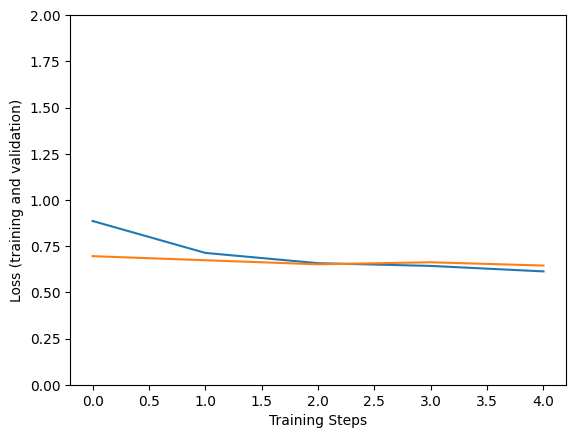

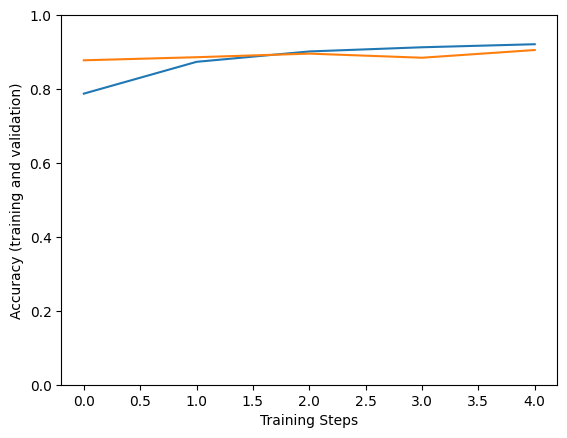

In [15]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Try out the model on an image from the validation data:

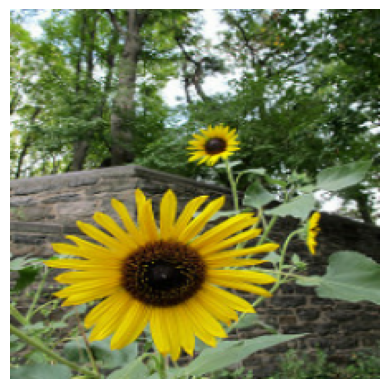

1/1 [==============================] - 2s 2s/step
True label: sunflowers
Predicted label: sunflowers


In [16]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])